# Packages

In [1]:
# Packages
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import imageio
import cv2

# Mount Drive and Load Data and Load Final Model

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# open zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/Data/combinedData.zip', 'r')

# create folder with combined data
zip_ref.extractall('/content/BloodCellData')
zip_ref.close()

In [4]:
# Train Data Directory
datadir = '../content/BloodCellData/Combined Data'

print("Data Directory Folders:", os.listdir(datadir))

Data Directory Folders: ['LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE']


In [5]:
# Image Size
image_width = 320
image_height = 240

# Split the data to training
train_images = tf.keras.utils.image_dataset_from_directory(
    datadir,
    label_mode='int',
    validation_split=0.30,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the data to validation and testing
val_test_images = tf.keras.utils.image_dataset_from_directory(
    datadir,
    label_mode='int',
    validation_split=0.30,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the val_test_images into validation and testing images
validation_images = val_test_images.take(int(len(val_test_images) * 0.5))
test_images = val_test_images.skip(int(len(val_test_images) * 0.5))

# Class Names
class_names = train_images.class_names
print("Class Names:", class_names)

Found 12436 files belonging to 4 classes.
Using 8706 files for training.
Found 12436 files belonging to 4 classes.
Using 3730 files for validation.
Class Names: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [6]:
# Code for Loading trained tuned model
saved_models_path = '/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/Saved_Models'

trained_tuned_model = os.path.join(saved_models_path, "trained_tuned_model.h5")

model = tf.keras.models.load_model(trained_tuned_model)

In [7]:
# Quick evaluate confirmation that it matches Preprocessing and Modeling notebook
# Note that the values may be slightly different due to the shuffling done in image_dataset_from_directory when batching

loss, accuracy = model.evaluate(test_images)
print("Loss:", loss)
print("Accuracy:", accuracy)

59/59 [==============================] - 18s 133ms/step - loss: 0.1074 - accuracy: 0.9632
Loss: 0.10735306888818741
Accuracy: 0.9631803631782532


# Model Evaluation and Investigation

In [8]:
# Extract Images and Labels from test_images batches 
test_img = []
test_lab = []

for image, label in test_images.take(-1):
  test_img.append(image)
  test_lab.append(label)

In [9]:
# Flatten images and labels lists
images = [img for img_list in test_img for img in img_list]
labels = [label.numpy().tolist() for label_list in test_lab for label in label_list]

# Create prediction list
predictions = []

for i in range(len(test_img)):
  pred = model.predict(test_img[i])
  pred = np.argmax(pred, axis=1)
  predictions.extend(pred)

print("True Labels:", labels[:5])
print("Predictions:", predictions[:5])

True Labels: [0, 1, 1, 1, 3]
Predictions: [0, 1, 1, 1, 3]


## Confusion Matrix

In [10]:
def plot_confusion_matrix(lab, pred):
  '''
  Creates and graphs the confusion matrix
  '''
  print(classification_report(lab, pred, target_names=class_names))

  cm = confusion_matrix(lab, pred)
  g = sns.heatmap(cm,
                  cmap='Blues',
                  linecolor='Black',
                  linewidth=1,
                  annot=True,
                  fmt='d',
                  xticklabels=class_names,
                  yticklabels=class_names)
  g.set_xlabel("True Label", fontsize=10)
  g.set_ylabel("Prediction Label", fontsize=10)

              precision    recall  f1-score   support

  EOSINOPHIL       0.94      0.94      0.94       471
  LYMPHOCYTE       0.99      0.98      0.99       481
    MONOCYTE       1.00      0.99      0.99       447
  NEUTROPHIL       0.93      0.95      0.94       475

    accuracy                           0.97      1874
   macro avg       0.97      0.97      0.97      1874
weighted avg       0.97      0.97      0.97      1874



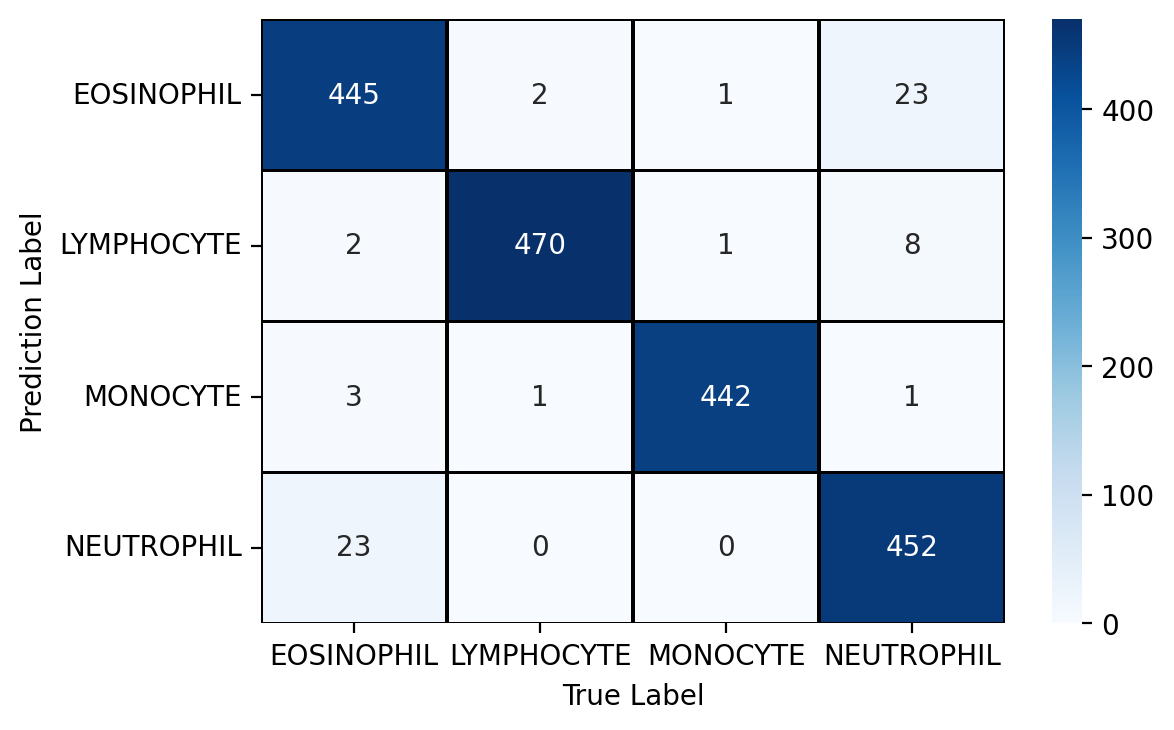

In [11]:
plt.rcParams['figure.dpi'] = 200
plot_confusion_matrix(predictions, labels)

In [12]:
# Prediction Accuracy
correct_pred = np.where(np.array(predictions)==np.array(labels))[0]
print("Predicted correctly :", len(correct_pred))

incorrect_pred = np.where(np.array(predictions)!=np.array(labels))[0]
print("Predicted incorrectly :", len(incorrect_pred))

Predicted correctly : 1809
Predicted incorrectly : 65


From a total of 1874 test images, my model was able to classify 1809 of the images correctly and 65 of the images incorrectly, which is a 97% accuracy. Looking at the classification report and confusion matrix, it looks like the model is having a difficult time differentiating between Eosinophils and Neutrophil, mixing up the classification the most between these two.
This may be due to the fact that both Neutrophil and Eosinophils have the similar characteristic of being are multi-lobed, which can form similar shapes.

In [13]:
def ohe_to_class(ohe):
  '''
  Converts ohe back into cell type name
  '''
  if ohe == 0:
    cellType = "EOSINOPHIL"
  elif ohe == 1:
      cellType = "LYMPHOCYTE"
  elif ohe == 2:
    cellType = "MONOCYTE"
  else:
     cellType = "NEUTROPHIL"
      
  return(cellType)

In [14]:
def classification_plot(set_list, num_img, plot_dim):
  rand_set = np.random.choice(set_list, num_img, replace=False)

  for i, img in enumerate(rand_set):
    plt.subplot(plot_dim,plot_dim,i+1)
    plt.imshow(images[img].numpy().astype("uint8"), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Label: {}".format(ohe_to_class(predictions[img]), ohe_to_class(labels[img])),  fontsize=5)
    plt.axis("off")
    plt.suptitle("Randomly Chosen Subset of {} Images".format(num_img), size=10)

  plt.figure(figsize=(20, 20))

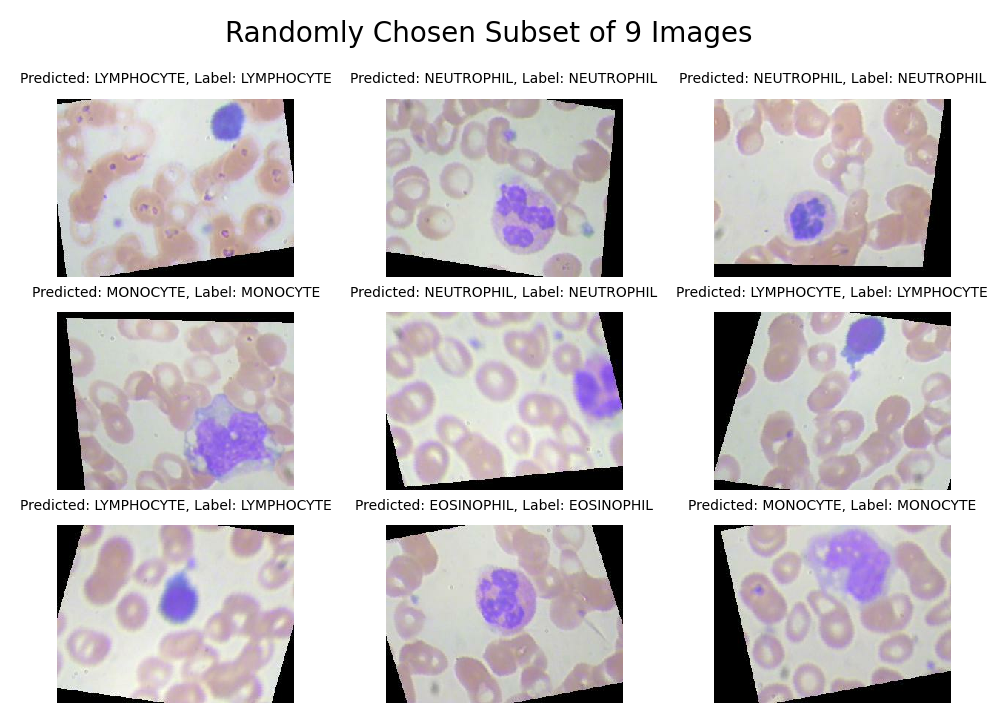

<Figure size 4000x4000 with 0 Axes>

In [15]:
# Randomly select 9 images from the correctly predicted set
classification_plot(correct_pred, 9, 3)

The images that the model was able to classify are clean and whole images of the stained cells. The shape and lobes are well defined.

## Incorrectly Predicted Images

Total Number of Incorrect Predictions for EOSINOPHIL: 26


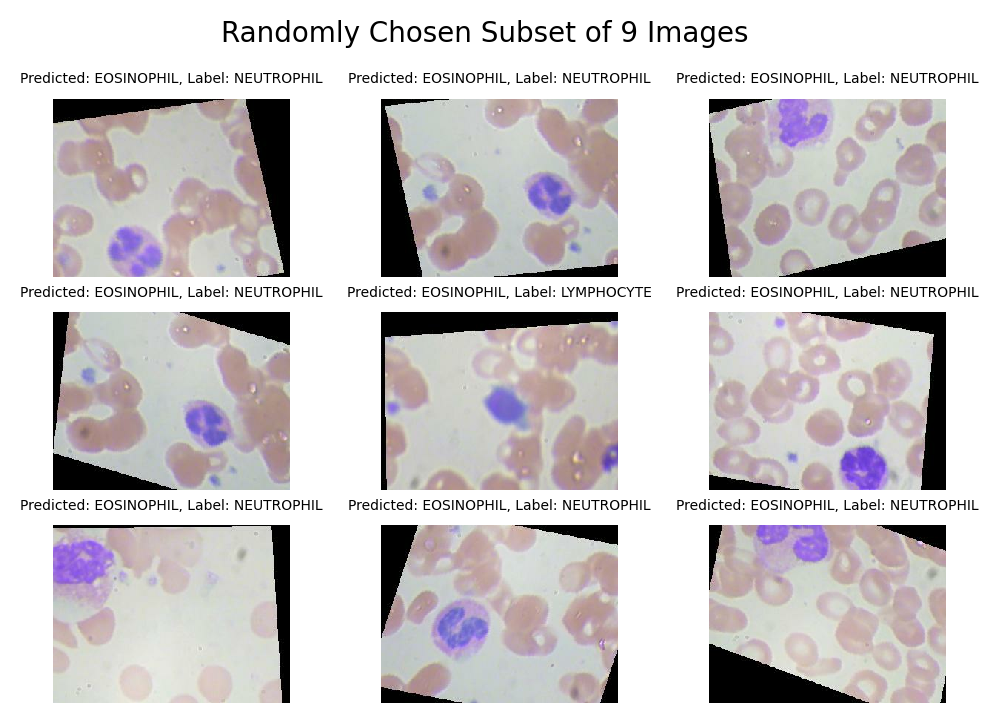

<Figure size 4000x4000 with 0 Axes>

In [17]:
# Incorrectly Predicted EOSINOPHIL
incorrect_eosi = np.where((np.array(predictions)!=np.array(labels)) & (np.array(predictions)==0))[0]
print("Total Number of Incorrect Predictions for EOSINOPHIL:", len(incorrect_eosi))

classification_plot(incorrect_eosi, 9, 3)

Total Number of Incorrect Predictions for LYMPHOCYTE: 11


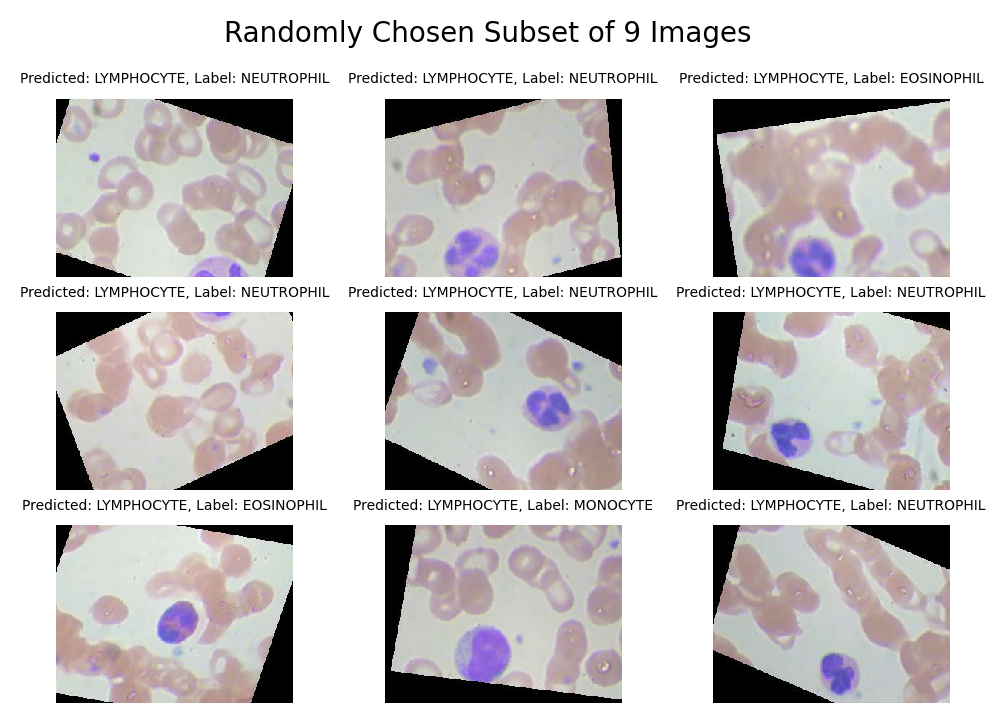

<Figure size 4000x4000 with 0 Axes>

In [18]:
# Incorrectly Predicted LYMPHOCYTE
incorrect_lymp = np.where((np.array(predictions)!=np.array(labels)) & (np.array(predictions)==1))[0]
print("Total Number of Incorrect Predictions for LYMPHOCYTE:", len(incorrect_lymp))

classification_plot(incorrect_lymp, 9, 3)

Total Number of Incorrect Predictions for MONOCYTE: 5


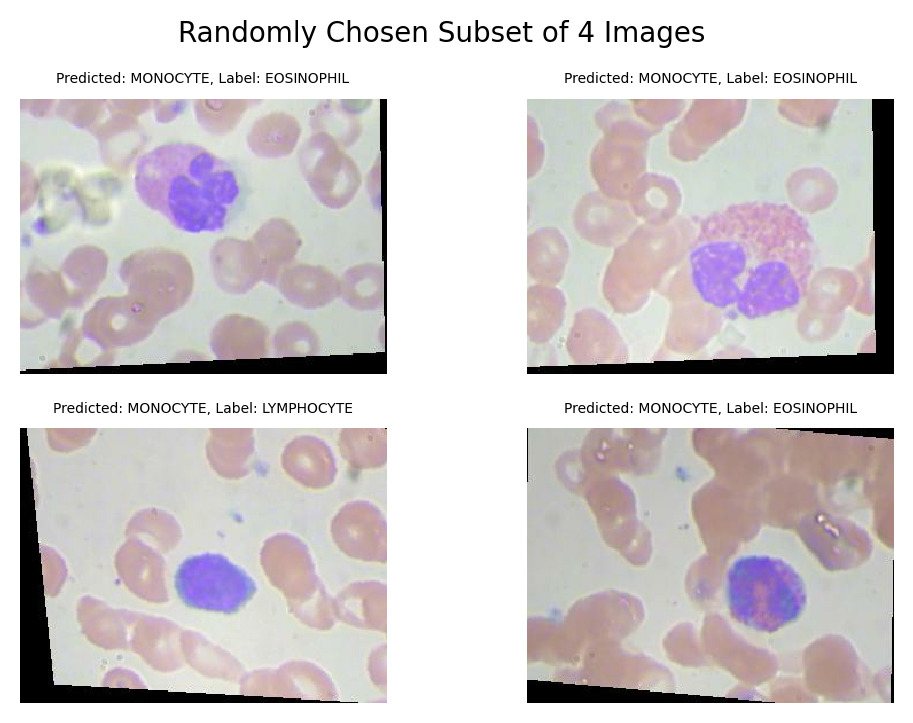

<Figure size 4000x4000 with 0 Axes>

In [19]:
# Incorrectly Predicted MONOCYTE
incorrect_mono = np.where((np.array(predictions)!=np.array(labels)) & (np.array(predictions)==2))[0]
print("Total Number of Incorrect Predictions for MONOCYTE:", len(incorrect_mono))

classification_plot(incorrect_mono, 4, 2)

Total Number of Incorrect Predictions for NEUTROPHIL: 23


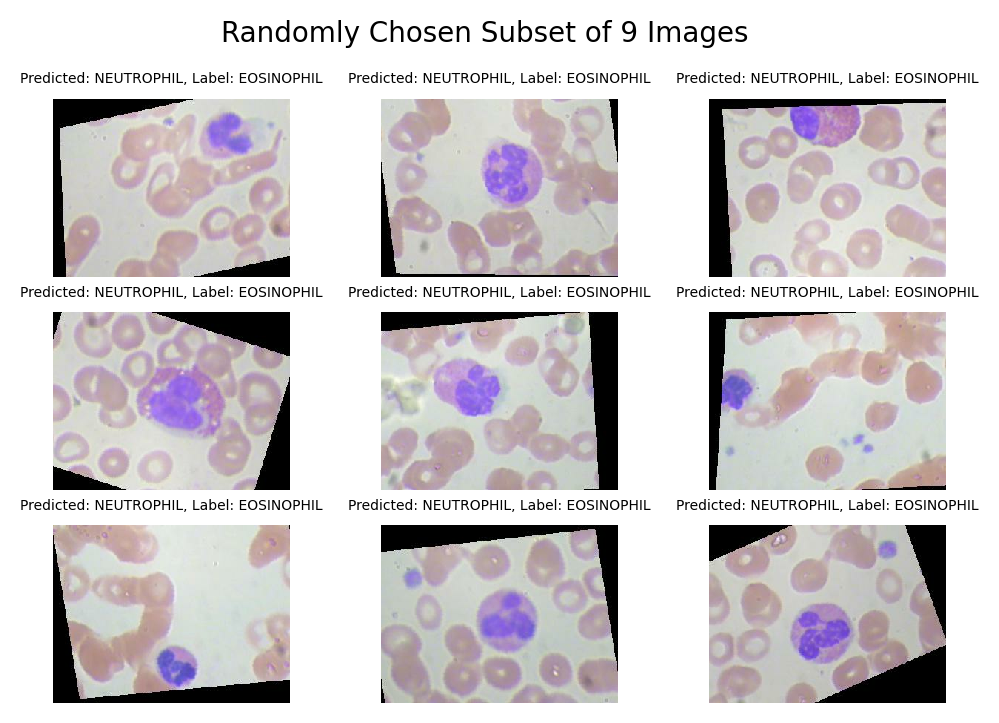

<Figure size 4000x4000 with 0 Axes>

In [20]:
# Incorrectly Predicted NEUTROPHIL
incorrect_neut = np.where((np.array(predictions)!=np.array(labels)) & (np.array(predictions)==3))[0]
print("Total Number of Incorrect Predictions for NEUTROPHIL:", len(incorrect_neut))

classification_plot(incorrect_neut, 9, 3)

Looking at randomly subsetted images of where the model misclassified, a common trend in most of the pictures are spilled purple stains that are not part of the white blood cell's staining. The model may accidently be considering these spilled stain when judging its shape or the number of lobes, especially between the Neutrophil and Eosinophil. But additional stains will misclassifiy single lobed white blood cells that are monocytes or lymphocytes.

In some cases where the model misclassified, the images of the cells are not very clean or distinct to their true labeled white blood cell. An example can be seen in the incorrectly predicted monocytes, where the bottom left image appears to be a lymphocyte given that the kidney bean shape isn't very clear.

# Follow-Up and Further Projects

The total number of training images were 12436. This is a large amount of images, but neural networks, especially image classifications benefit and become confident and reliable when given even larger training sets. Transfer learning models like the Xception that was used as the base for this model was trained on 1.4 million images from 1000 different classes. A follow-up project to help tune the model even further would be to use an image generator / augmentation, to create even more training data. But also collecting newer images would be more beneficial then just augmenting the current set of images.

Another type of model that could be investigated would be to classify if the white blood cell is either monolobed or polylobed rather then classifying into 4 different groups. This would limit the model prediction to 2, which will still given plenty of medical information, but have increased confidence in its ability to classify accurately and efficiently.

Applications for this model can extend to not just white blood cells, but to classify other types of cells in the human body. Both for medical diagnosis like counting cells or identifying cancer cells to research settings like drug discovery.